In [1]:
import os
# % load_ext autoreload
# % autoreload 2
import sys

sys.path.append('/home/labs/amit/noamsh/repos/sc_clustering')

In [2]:
from pathlib import Path
import shutil
import anndata as ad
import scanpy as sc
import pandas as pd
import scvi

import config
from utils import get_now_timestemp_as_string
from data.meta_data_columns_names import TREATMENT_ARM
from clustering.scanpy_cluster import pp_drop_genes_and_cells

In [3]:
CREATE_NEW_RESULTS_DIR = True

experiment_name = f"scvi_on_raw_gene_counts_{get_now_timestemp_as_string()}"
experiment_results_dir_path = Path(config.RESULTS_DIR, experiment_name)
if CREATE_NEW_RESULTS_DIR:
    os.mkdir(experiment_results_dir_path)

asaf_meta_cell_dir_path = Path("/home/labs/amit/weiner/Serono/Serono14/clustering_results/simple_clustering_2021_09_05__15_04_43")
old_adata_path = Path(asaf_meta_cell_dir_path, "cells.h5ad")
new_adata_path = Path(experiment_results_dir_path, "cells.h5ad")
if CREATE_NEW_RESULTS_DIR:
    shutil.copyfile(old_adata_path, new_adata_path)

In [22]:
adata = ad.read_h5ad(new_adata_path)
adata

AnnData object with n_obs × n_vars = 163892 × 23465
    obs: 'Plate number', 'arm.day.batch.mouse', 'mouse.gate.id', 'MouseTumorType', 'Treatment Arm', 'Day of tumor harvest', 'Experimental Batch ID', 'MouseNum', 'Frozen', 'Sorting date', 'Gate', 'Notes', 'Partial plate', 'Index beginning time', 'Index file', 'Accudrop done before plate', 'Sorting Notes', 'Experimental Batch', 'Batch.Set.ID', 'Seq.Batch.ID', 'Amp.Batch.ID', 'Biological replicate', 'Staining panel ID', 'Staining panel name', 'Institute', 'Libraries date', 'Use for analysis', 'Analysis notes', 'Cell count', 'Cells per plate', 'properly_sampled_cell', 'clean_cell', 'full_cell_index', 'cells_rare_gene_module', 'rare_cell', 'pre_cell_directs', 'cell_directs', 'pre_pile', 'pile', 'pre_candidate', 'candidate', 'pre_cell_deviant_votes', 'cell_deviant_votes', 'pre_dissolved', 'dissolved', 'pre_metacell', 'metacell', 'outlier'
    var: 'properly_sampled_gene', 'excluded_gene', 'noisy_lonely_gene', 'clean_gene', 'full_gene_index'

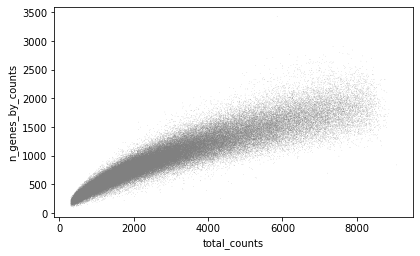

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
n_genes = 2000
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=n_genes,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key=TREATMENT_ARM
)
adata

In [ ]:
scvi.data.setup_anndata(adata, layer="counts", batch_key=TREATMENT_ARM)
model = scvi.model.SCVI(adata)
model.train()
model.save(Path(experiment_results_dir_path,"model_with_batch/"))
adata.obsm["X_scVI"] = model.get_latent_representation()

In [ ]:
scvi.data.setup_anndata(adata, layer="counts")
model_baseline = scvi.model.SCVI(adata)
model_baseline.train()
model_baseline.save(Path(experiment_results_dir_path,"model_with_no_batch/"))

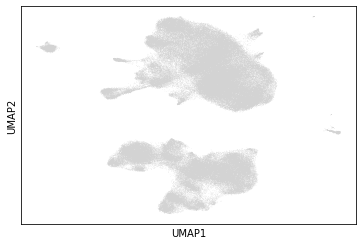

In [50]:
adata.obsm["X_scVI_base_line"] = model_baseline.get_latent_representation()

In [ ]:
adata.write(Path(experiment_results_dir_path, "adata_with_scvi.h5ad"))

In [19]:
adata_with_scanpy = ad.read_h5ad(Path(asaf_meta_cell_dir_path, "scanpy_metacells.h5ad"))
adata_with_scanpy.obs[['cell_type', 'broad_cell_type']]

,cell_type,broad_cell_type
0,T-M doublet,Doublet
1,T-M doublet,Doublet
2,T-M doublet,Doublet
3,CD8_Pdcd1,CD8
4,pDC_Ccr9,DC
...,...,...
2921,Treg,Treg
2922,NK_Spp1,NK
2923,Treg,Treg
2924,NK_Spp1,NK


In [23]:
adata.obs = pd.merge(left=adata.obs,
                     right=adata_with_scanpy.obs[["cell_type", "broad_cell_type"]].reset_index().astype({"index": 'int32'}),
                     left_on="metacell", right_on="index", how="left")

sum(adata.obs["broad_cell_type"].isna())

1962

In [76]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[TREATMENT_ARM, "cell_type"])


AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



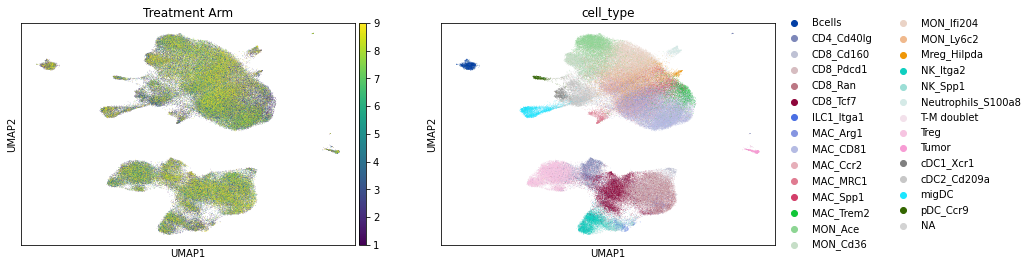

In [78]:
sc.pp.neighbors(adata, use_rep="X_scVI_base_line")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[TREATMENT_ARM, "cell_type"])